## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

Your full name:

### Imports

Feel free to add to this section as needed.

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

from PIL import Image
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

BATCH_SIZE = 32

Detect which device (CPU/GPU) to use.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [4]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        self.net = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)
        self.net.fc = nn.Identity() # Identity = the output is the same as the input to that layer, i.e. unchanged
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # return features 
        with torch.no_grad():
            return self.net(images)


In [5]:
# instantiate encoder and put into evaluation mode.
model = EncoderCNN()
model = model.to(device) # Set model to gpu
model.eval()
print(model)

EncoderCNN(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [7]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [8]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


file_name
0     000000000009.jpg
1     000000000025.jpg
2     000000000030.jpg
3     000000000034.jpg
4     000000000036.jpg
...                ...
5063  000000581906.jpg
5064  000000581909.jpg
5065  000000581913.jpg
5066  000000581921.jpg
5067  000000581929.jpg

[5068 rows x 1 columns]

In [9]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

IMAGE_DIR = "coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        
        self.root = IMAGE_DIR # path to coco images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        
        if self.transform:
            image = Image.open(self.root + filename)
            if image.mode == 'L': # convert grey-scales to RGB, 
                # otherwise transform normalize causes error due to shape mismatch
                image = image.convert('RGB')
                
            image = self.transform(image)
            
        return image, filename

    def __len__(self):
        return len(self.df)

In [10]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
data_set = COCOImagesDataset(df_unique_files, data_transform)

data_loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=16,
    shuffle=False
)

In [11]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this
features_map = dict()

def get_image_ids(filenames): # from filename, obtain the id
    ids = []
    for name in filenames:
        ids.append(imageList.loc[imageList['file_name'] == name]['id'].iloc[0])
    return ids

with torch.no_grad():
    for imgs, filenames in tqdm(data_loader):
        img_ids = get_image_ids(filenames) 
        imgs = imgs.cuda()
        # obtain output features from encoder for the batch of images
        features = model(imgs)
        for i in range(len(img_ids)):
            features_map[img_ids[i]] = features[i]
 
torch.save(features_map, 'encodings.pt')

  0%|          | 0/317 [00:00<?, ?it/s]

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [10]:
import json

# loading captions for training
with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

image_id   id                                            caption
0    203564   37  A bicycle replica with a clock as the front wh...
1    322141   49  A room with blue walls and a white sink and door.
2     16977   89  A car that seems to be parked illegally behind...
3    106140   98  A large passenger airplane flying through the ...
4    106140  101  There is a GOL plane taking off in a partly cl...

In [11]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("coco_subset_meta.csv")
# --> your code here! - name the new dataframe as "new_file"
# Get unique images from the csv for extracting features - helper code
new_file = pd.DataFrame(columns=['image_id', 'file_name', 'caption'])

for uq_name in df_unique_files['file_name']:
    # get the id of the unique img
    img_id = coco_subset.loc[coco_subset['file_name'] == uq_name]['id'].iloc[0]
    # get the list of 5 captions for that image
    captions = df.loc[df['image_id'] == img_id]['caption']
    # add new row to dataframe that contains the id, file and the respective caption, e.g.
    # 5 rows per unique image in the new df
    for caption in captions:
        new_file.loc[len(new_file)] = {'image_id': img_id, 'file_name': uq_name, 'caption': caption}
        
new_file.head()

image_id         file_name  \
0         9  000000000009.jpg   
1         9  000000000009.jpg   
2         9  000000000009.jpg   
3         9  000000000009.jpg   
4         9  000000000009.jpg   

                                             caption  
0  Closeup of bins of food that include broccoli ...  
1  A meal is presented in brightly colored plasti...  
2  there are containers filled with different kin...  
3  Colorful dishes holding meat, vegetables, frui...  
4         A bunch of trays that have different food.

#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [13]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):
    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space

    for index, row in df.iterrows():
        # Replace all non-alphabet characters with space
        clean_caption = "".join([ c if c.isalpha() else " " for c in row['caption']]) 
        # Replace all continuous spaces with a single space
        clean_caption = ' '.join(clean_caption.split())
        # Remove spaces in the beginning and at the end. Convert to lower case
        clean_caption = clean_caption.strip().lower() 
        # add to dataframe
        df.at[index,'clean_caption'] = clean_caption

    return df

In [14]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

image_id         file_name  \
0         9  000000000009.jpg   
1         9  000000000009.jpg   
2         9  000000000009.jpg   
3         9  000000000009.jpg   
4         9  000000000009.jpg   
5        25  000000000025.jpg   
6        25  000000000025.jpg   
7        25  000000000025.jpg   
8        25  000000000025.jpg   
9        25  000000000025.jpg   

                                             caption  \
0  Closeup of bins of food that include broccoli ...   
1  A meal is presented in brightly colored plasti...   
2  there are containers filled with different kin...   
3  Colorful dishes holding meat, vegetables, frui...   
4         A bunch of trays that have different food.   
5    A giraffe eating food from the top of the tree.   
6               A giraffe standing up nearby a tree    
7      A giraffe mother with its baby in the forest.   
8       Two giraffes standing in a tree filled area.   
9  A giraffe standing next to a forest filled wit...   

                                       clean_caption  
0  closeup of bins of food that include broccoli ...  
1  a meal is presented in brightly colored plasti...  
2  there are containers filled with different kin...  
3  colorful dishes holding meat vegetables fruit ...  
4          a bunch of trays that have different food  
5     a giraffe eating food from the top of the tree  
6                a giraffe standing up nearby a tree  
7       a giraffe mother with its baby in the forest  
8        two giraffes standing in a tree filled area  
9  a giraffe standing next to a forest filled wit...

#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [15]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [93]:
img_ids = new_file['image_id'].unique()
train_set_ids, val_set_ids, test_set_ids = split_ids(img_ids)

train_set = new_file.loc[new_file['image_id'].isin(train_set_ids)]
val_set = new_file.loc[new_file['image_id'].isin(val_set_ids)]
test_set = new_file.loc[new_file['image_id'].isin(test_set_ids)]

In [94]:
print('Sanity check for allocated dataframes')
print('NOTE: Proportions of 70/10/20 % should be preserved in the number of images and number of captions (5 captions per image id)!')

print(f'Train set images: {int(len(train_set) / 5)}')
print(f'Validation set size: {int(len(val_set) / 5)}')
print(f'Test set size: {int(len(test_set) / 5)}')
print(f'Total data size: {(int((len(train_set) + len(val_set) + len(test_set)) / 5))}')

Sanity check for allocated dataframes
NOTE: Proportions of 70/10/20 % should be preserved in the number of images and number of captions (5 captions per image id)!
Train set images: 3548
Validation set size: 506
Test set size: 1015
Total data size: 5069


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [36]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [37]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        captions = new_file.loc[new_file['image_id']==id]['clean_caption'].values
        words = ' '.join(captions).split()
        for word in words:
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        if word_mapping[word] > 3:
            vocab.add_word(word)

    return vocab


In [38]:
# build your vocabulary for train, valid and test sets
vocab_set = (train_set_ids, val_set_ids, test_set_ids)
vocab = build_vocab(np.concatenate(vocab_set, axis=None), new_file)

In [39]:
print(f'Vocab size should be ~2200; was: {len(vocab)}')

Vocab size should be ~2200; was: 2731


#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [22]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        self.df = df
        self.features = features
        self.vocab = vocab

    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
        img_id = self.df.iloc[index]['image_id']
        features = self.features[img_id]
        
        cap_ids = torch.empty(MAX_SEQ_LEN, dtype=torch.int32)
        caption_words = self.df.iloc[index]['clean_caption'].split() # words in caption are separated by space
        true_length = len(caption_words) + 1 # including the end token
        for i in range(MAX_SEQ_LEN):
            if i < (true_length - 1):
                cap_ids[i] = self.vocab(caption_words[i]) # add respective word id tokens
            elif i == (true_length - 1):
                cap_ids[i] = self.vocab('<end>') # make sure to add the end token at the end 
            else:
                cap_ids[i] = self.vocab('<pad>') # include padding until word ids reach MAX_SEQ_LEN
            
        return features, cap_ids, true_length
    
    def __len__(self):
        return len(self.df)
    

In [23]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (feature, clean_caption, true_length).
    Args:
        data: list of tuple (feature, clean_caption, true_length). 
            - features: torch tensor of shape (1, 2048).
            - caption_ids: torch tensor of shape (1, 47).
            - true_length: torch tensor value containing the true size of caption
    Returns:
        features: torch tensor of shape (batch_size, 2048).
        targets: torch tensor of shape (batch_size, variable_length).
        lengths: list; true length of each target.
    """
    
    # Sort a data list by caption length from longest to shortest.
    data.sort(reverse = True, key = lambda t: t[2])
    # the max caption length in the batch is the first item in the sorted list
    max_length = data[0][2]
    
    # merge features. 1D tensor to 2D tensor. (batch_size, 2048)
    features = torch.stack([i[0] for i in data])
    
    # merge captions (from tuple of 1D tensor to 2D tensor).
    raw_targets = [i[1] for i in data]
    targets = torch.stack([i[:max_length] for i in raw_targets])

    # merge true lengths (from tuple of 1D tensor to 2D tensor).
    lengths = [i[2] for i in data]
    return features, targets, lengths


In [24]:
# load extracted features from Section 1.2
features_map = torch.load('encodings.pt')

In [95]:
train_dataset = COCO_Features(
    df=train_set,
    features = features_map,
    vocab=vocab
)

val_dataset = COCO_Features(
    df=val_set,
    features = features_map,
    vocab=vocab
)

#  your dataloader here (make shuffle true as you will be training RNN)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, collate_fn=caption_collate_fn)

# Do the same as above for your validation set
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True, collate_fn=caption_collate_fn)

Load one batch of the training set and print out the shape of each returned Tensor.

In [96]:
test_batch = next(iter(train_loader))
for item in test_batch:
    if type(item) == torch.Tensor:
        print(item.shape)
    else:
        print(len(item))

torch.Size([32, 2048])
torch.Size([32, 16])
32


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [27]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear, activation and dropout layers to resize
        
        self.network = nn.Sequential(
          nn.Linear(2048,embed_size),
          nn.ReLU(),
          nn.Dropout(p=0.2)
        )
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        # your code for RNN
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # self.linear: linear layer with input: hidden layer, output: vocab size
        self.linear = nn.Linear(in_features=hidden_size, out_features=vocab_size)
       
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions) # batch_size x (sequences) padded_batch_length x embed_size
        im_features = self.network(features)
        im_features = self.bn(im_features) # batch_size x embed_size
        # compute your feature embeddings
        embeddings = torch.cat( (im_features.unsqueeze(1), embeddings), dim=1)

        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].
        embeddings = pack_padded_sequence(embeddings, lengths, batch_first=True)
        # instead of using the embeddings.data we can obtain better results by feeding in the
        # embeddings themselves, for that reason we perform the inverse of pack_padded_sequence
        # to obtain the embeddings tensor
        embeddings = pad_packed_sequence(embeddings, batch_first=True)[0]
        hiddens, states = self.rnn(embeddings)

        outputs = self.linear(hiddens) #hint: use a hidden layers in parenthesis
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.network(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            if predicted == 2: # terminate generation of tokens at <end>
                break
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [98]:
# instantiate decoder
decoder = DecoderRNN(len(vocab))
decoder = decoder.to(device)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [47]:
def train(train_loader, val_loader, decoder, loss_fn, optimizer, num_epochs=50, results_name='train_results.pt'):
    statsrec = np.zeros((2,num_epochs)) # record loss for testing & validation
    for epoch in range(num_epochs):
        train_loss = 0
        n = 0
        decoder.train() # activate training mode
        for i, (features, captions, lengths) in enumerate(train_loader):
            if torch.cuda.is_available():
                features, captions = features.to(device), captions.to(device)
            targets = captions.to(device)
            outputs = decoder(features, captions, lengths)
            loss = loss_fn(outputs.permute(0,2,1), targets.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            n += 1
        train_loss = train_loss / n
        print(f'Epoch {epoch}, Training Loss: {train_loss}')
        
        val_loss = 0
        n = 0
        decoder.eval() # do not compute gradients when validating
        for i, (features, captions, lengths) in enumerate(val_loader):
            if torch.cuda.is_available():
                features, captions = features.to(device), captions.to(device)
            targets = captions.to(device)
            outputs = decoder(features, captions, lengths)
            loss = loss_fn(outputs.permute(0,2,1), targets.long())
            val_loss += loss.item()
            n += 1
            
        val_loss = val_loss / n
        print(f'Epoch {epoch}, Validation Loss: {val_loss}')
        statsrec[:,epoch] = (train_loss, val_loss)
        torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_name)

In [99]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(decoder.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1)
train(train_loader, val_loader, decoder, loss_fn, optimizer, 100)

Epoch 0, Training Loss: 2.904854231267362
Epoch 0, Validation Loss: 2.386371333897114
Epoch 1, Training Loss: 2.249769002145475
Epoch 1, Validation Loss: 2.1781772434711457
Epoch 2, Training Loss: 2.0952697293178457
Epoch 2, Validation Loss: 2.1319873347878455
Epoch 3, Training Loss: 2.0259432126809886
Epoch 3, Validation Loss: 2.0630606561899185
Epoch 4, Training Loss: 1.975628357964593
Epoch 4, Validation Loss: 2.054359970986843
Epoch 5, Training Loss: 1.9259121140918216
Epoch 5, Validation Loss: 2.0234893910586833
Epoch 6, Training Loss: 1.9003637669322726
Epoch 6, Validation Loss: 2.009753543138504
Epoch 7, Training Loss: 1.8710092827006504
Epoch 7, Validation Loss: 2.0005762562155724
Epoch 8, Training Loss: 1.8571789546055837
Epoch 8, Validation Loss: 1.9626329392194748
Epoch 9, Training Loss: 1.8454532722095112
Epoch 9, Validation Loss: 1.9855002075433732
Epoch 10, Training Loss: 1.8408767918208697
Epoch 10, Validation Loss: 1.9944400653243064
Epoch 11, Training Loss: 1.821690039

Epoch 92, Training Loss: 1.7287342718055656
Epoch 92, Validation Loss: 1.8974073499441146
Epoch 93, Training Loss: 1.7357526449469833
Epoch 93, Validation Loss: 1.9188482284545898
Epoch 94, Training Loss: 1.7332042903513523
Epoch 94, Validation Loss: 1.9320790395140648
Epoch 95, Training Loss: 1.7299310001167092
Epoch 95, Validation Loss: 1.9146797128021718
Epoch 96, Training Loss: 1.7249002787443968
Epoch 96, Validation Loss: 1.915554515272379
Epoch 97, Training Loss: 1.7233344341183567
Epoch 97, Validation Loss: 1.915493008494377
Epoch 98, Training Loss: 1.7226808912045246
Epoch 98, Validation Loss: 1.910189689695835
Epoch 99, Training Loss: 1.7142084023973962
Epoch 99, Validation Loss: 1.8840327002108097


In [100]:
# utility function to graph stats for models
def plot_model_train_stats(results_path, 
                           fig_name: str="roc.svg", 
                           title: str="Training and validation loss",
                           nepochs=None):
    data = torch.load(results_path)
    statsrec = data["stats"]
    if nepochs != None:
        statsrec = statsrec[:,:nepochs]
        
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[1], 'g', label = 'validation loss' )
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()

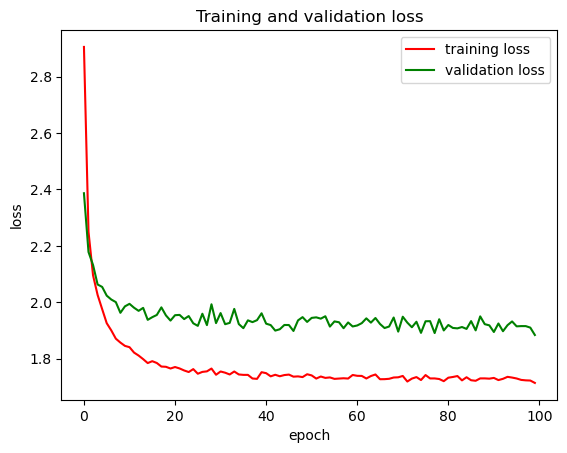

In [101]:
plot_model_train_stats('train_results.pt')

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [127]:
final_net = DecoderRNN(len(vocab))
final_net = final_net.to(device)
final_net.eval()
# checkpoint = torch.load("final.pt")
checkpoint = torch.load("train_results.pt")
final_net.load_state_dict(checkpoint['state_dict'])

test_dataset = COCO_Features(
    df=test_set,
    features = features_map,
    vocab=vocab
)

def test(model):
    img_ids = []
    predicted_captions = []

    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(test_dataset):
            if torch.cuda.is_available():
                features, captions = features.unsqueeze(0).to(device), captions.unsqueeze(0).to(device)
            img_ids.append(test_set.iloc[i]['image_id'])
            predicted_captions.append(model.sample(features))
    
    return img_ids, predicted_captions
        
img_ids, captions = test(final_net)

In [128]:
# convert tokens to the word representation
all_word_captions = []
i = 0
for cap in captions:
    the_caption = []
    for id in cap[0]:
        id = id.item()
        if id == 2: # skip end token
            continue
        the_caption.append(vocab.idx2word[id])
    all_word_captions.append(" ".join(the_caption))
    i += 1


Image_id: 34
Image name:  000000000034.jpg

Reference captions: 

a zebra grazing on lush green grass in a field
zebra reaching its head down to ground where grass is
the zebra is eating grass in the sun
a lone zebra grazing in some green grass
a zebra grazing on grass in a green open field

Predicted caption:  a zebra standing in a field with a zebra in the background


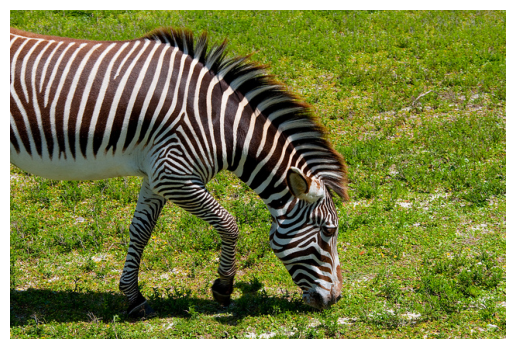

____________________________________________________________________

Image_id: 94
Image name:  000000000094.jpg

Reference captions: 

there is a street lined with packed buildings
there is a car driving down a street with buildings on each side
a street sign and a car on the road
this is a view of a quaint city street
a city street with a sign that reads peace way hotel

Predicted caption:  a street with cars and cars on the side of the road


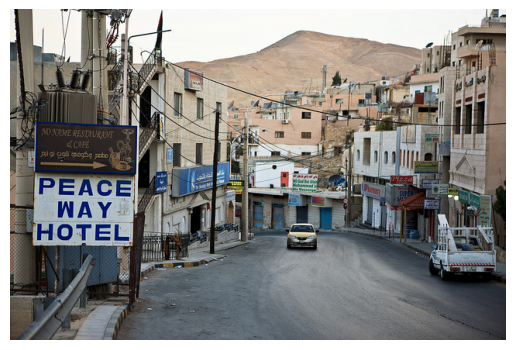

____________________________________________________________________

Image_id: 136
Image name:  000000000136.jpg

Reference captions: 

two giraffes in a room with people looking at them
two giraffe standing next to each other in a room
the giraffe is being kept by itself indoors
a man and woman staring at two giraffes through a window
a giraffe in a enclosed area is watched by some people

Predicted caption:  a giraffe standing in a living room with a <unk>


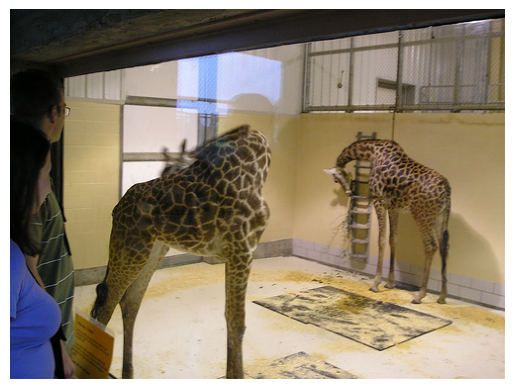

____________________________________________________________________

Image_id: 446
Image name:  000000000446.jpg

Reference captions: 

a standing woman with a remote control in hand
a woman holding a remote control in her right hand
a woman stands with a wii remote in her hand
a woman playing a video game indoors
a woman standing in a room holding a remote control

Predicted caption:  a woman in a room playing with a wii remote


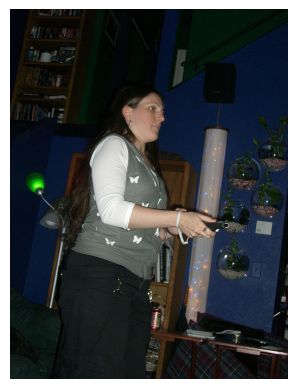

____________________________________________________________________

Image_id: 8193
Image name:  000000008193.jpg

Reference captions: 

a motorcycle sitting on the side of the rode with a bag on it
a close up shot of a motorcycle with a blue bag
a motorcycle with a bag on the back of it parked in the road
the motorcycle is parked on the side of the dirt road
a motorcycle parked on a dirt road with a backpack on it

Predicted caption:  a motorcycle parked on a dirt road in a field


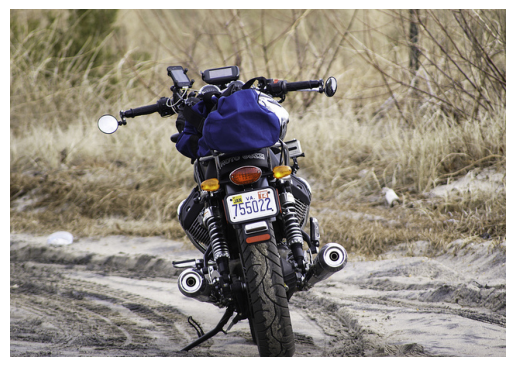

____________________________________________________________________


In [184]:
# utility function to display the predicted and reference captions for a given image
def display_info(i, ref_captions):
    print(f'\nImage_id: {img_ids[i]}')
    print('Image name: ', file_name)

    print('\nReference captions: \n')
    for caption in ref_captions:
        print(caption)
    print('\nPredicted caption: ', all_word_captions[i])
    

# utility function to display an image
def display_image(file_name):
    path = IMAGE_DIR + '/' + file_name
    im = plt.imread(path)
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    print('____________________________________________________________________')

# displays info on a selection of 5 images
selected_images = [0, 25, 35, 70, 80]

for i in range(0,len(img_ids),5): 
    if i in selected_images:
        rows = new_file.loc[new_file['image_id'] == img_ids[i]]
        file_name = rows.iloc[0,1]
        ref_captions = rows.iloc[:,3]
        display_info(i, ref_captions)
        display_image(file_name)
    

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [130]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
stats = pd.DataFrame(columns=['id','ref','preds','bleu','cos_sim'])#dict()

chencherry = SmoothingFunction()

for i in range(len(all_word_captions)):
    # get the corresponding prediction, reference captions for each image id
    rows = new_file.loc[new_file['image_id'] == img_ids[i]]
    pred = all_word_captions[i]
    ref = rows.iloc[i%5,3]
    bleu = sentence_bleu([pred.split()], ref.split(), smoothing_function=chencherry.method2)
    entry = pd.DataFrame({'ref': ref, 'preds': pred, 'bleu': bleu, 'cos_sim': 0}, index=[i])
    stats = pd.concat([stats, entry], ignore_index = True)

Average BLEU score: 0.16601374598284668


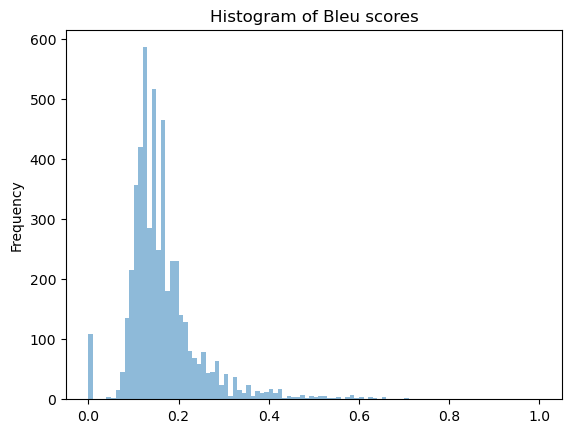

In [131]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5).set_title('Histogram of Bleu scores')

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [167]:
# utility function to prettily print the prediction reference and bleu/cos score
def print_score(pred, ref, score, mode):
    if mode == 'bleu':
        score_message = f'Bleu score: {score}\n'
    else:
        score_message = f'Cosine similarity score: {score}\n'
    print(f'Predicted caption: {pred}')
    print(f'Reference caption: {ref}')
    print(score_message)
    
# utility function to return the img_id and stats index of a selected entry.
# input: indeces - list of row indeces in stats that contain high/low score.
#                    list may contain indeces of non-unique image instances
#        choice - an integer that can be used to control which unique instance's
#                 image id and stats index to return. 
# Raises: list out of range exception if the choice exceeds the length of the
#         unique instances with high/low scores.
def obtain_selected_instance_ids(indeces, choice):
    # condense the list of high values only to unique images
    ids = []
    selection = []
    for i in indeces:
        if img_ids[i] not in ids:
            ids.append(img_ids[i])
            selection.append(i)
    # condense even further to the specific choice of instance and return
    return ids[choice], selection[choice]
    

In [159]:
high_indeces = []
low_indeces = []

# save the high and low score instance indexes
for index,row in stats.iterrows():
    # since we only need to find one instance in which the
    # prediction has high/low bleu score compared to the 
    # corresponding reference we can afford to be efficient
    # in this loop and check whether the first prediction
    # achieves sufficiently high/low score and obtain all
    # references later on
    bleu = row['bleu']
    img_id = row['id']

    if bleu > 0.8:
        high_indeces.append(index)
    if bleu < 0.1 and bleu > 0:
        low_indeces.append(index)
        
# prints all predictions/references and bleu scores for a given
# chosen instance. Depending on the mode prints either a high
# score instance or low score instance.
def display_bleu_info(mode, choice):
    if mode == 'high':
        print('Displaying high bleu score instance:\n')
        indeces = high_indeces
    else:
        print('Displaying low bleu scores instance:\n')
        indeces = low_indeces
        
    img_id, index = obtain_selected_instance_ids(indeces, choice)
    
    # first display the entry with high bleu score
    row = stats.iloc[index]
    high_bleu = row['bleu']
    print_score(row['preds'], row['ref'], high_bleu, 'bleu')
    
    # then display the 4 remaining captions for that instance
    for index,row in stats.iterrows():
        pred = row['preds']
        ref = row['ref']
        bleu = row['bleu']
        # to obtain the other 4 scores of that image instance,
        # check that the index of the row belongs to the same
        # image id as the choice and does not have the same
        # bleu score.
        if img_ids[index] == img_id and bleu != high_bleu:
            print_score(pred, ref, bleu, 'bleu')
    print('\n___________________________________________________\n')
    
display_bleu_info('high', 0)
display_bleu_info('low', 2)

Displaying high bleu score instance:

Predicted caption: a group of people flying kites in a field
Reference caption: a group of people flying kites in a field
Bleu score: 1.0

Predicted caption: a group of people flying kites in a field
Reference caption: a grassy field with many people flying kites
Bleu score: 0.28683767086078027

Predicted caption: a group of people flying kites in a field
Reference caption: a photograph of a adults and children flying their kites
Bleu score: 0.1623339577375495

Predicted caption: a group of people flying kites in a field
Reference caption: a group of people in an open field flying kites
Bleu score: 0.42728700639623407

Predicted caption: a group of people flying kites in a field
Reference caption: a large crowd of people play with kites on a clear day
Bleu score: 0.15851165692617156


___________________________________________________

Displaying low bleu scores instance:

Predicted caption: a man in a green green and white <unk>
Reference caption

## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [149]:
# TO COMPLETE
from numpy.linalg import norm
embed_size = 256

def compute_avg_embed(caption):
    sum_embed = torch.FloatTensor(embed_size).zero_()
    for word in caption:
        sum_embed += decoder.cpu().embed(torch.tensor(int(word)))
    return sum_embed / len(pred)

cos_sim = []
for i in range(len(img_ids)):
    cap = captions[i]
    # get the encoded caption vector of the predicted caption words, excluding the end token 
    pred = cap[0:len(cap-1)].float().cpu().numpy()[0]
    # compute the average vector of the embedding vector of each word in the predicted caption
    pred_avg = compute_avg_embed(pred).detach().numpy()

    rows = new_file.loc[new_file['image_id'] == img_ids[i]]
    ref = rows.iloc[i%5,3]
    # get the encoded reference caption vector
    ref_encoded = []
    for word in ref.split():
        if word in vocab.word2idx:
            ref_encoded.append(vocab.word2idx[word])
        else:
            ref_encoded.append(1) # <unk>
    # compute the average vector of the embedding vector of each word in the reference caption
    ref_avg = compute_avg_embed(ref_encoded).detach().numpy()
    
    # compute the cosine similarity between the prediction and reference caption
    cos_sim.append(np.dot(pred_avg,ref_avg)/(norm(pred_avg)*norm(ref_avg)))
    
stats['cos_sim'] = cos_sim

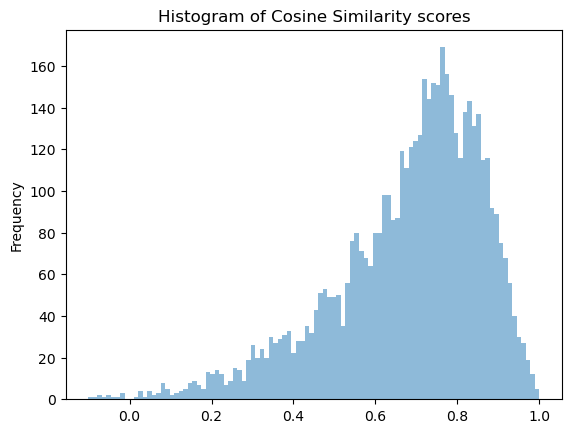

In [150]:
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5).set_title('Histogram of Cosine Similarity scores')

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [229]:
high_indeces = []
low_indeces = []
# save the high and low score instance indexes
for index,row in stats.iterrows():
    cos = row['cos_sim']

    if cos > 0.8:
        high_indeces.append(index)
    if cos < 0:
        low_indeces.append(index)

# prints all predictions/references and cos_sim scores for a given
# chosen instance. Depending on the mode prints either a high
# score instance or low score instance.
def display_cos_info(mode, choice):
    if mode == 'high':
        print('Displaying high cosine similarity score instance:\n')
        indeces = high_indeces
    else:
        print('Displaying low cosine similarity scores instance:\n')
        indeces = low_indeces
    
    img_id, index = obtain_selected_instance_ids(indeces, choice)
    
    # first display the entry with high cos score
    row = stats.iloc[index]
    high_cos = row['cos_sim']
    print_score(row['preds'], row['ref'], high_cos, 'cos')
    
   # then display the 4 remaining captions for that instance
    for index,row in stats.iterrows():
        pred = row['preds']
        ref = row['ref']
        cos = row['cos_sim']
        # to obtain the other 4 scores of that image instance,
        # check that the index of the row belongs to the same
        # image id as the choice and does not have the same
        # bleu score.
        if img_ids[index] == img_id and cos != high_cos:
            print_score(pred, ref, cos, 'cos')
    print('\n___________________________________________________\n')
    
display_cos_info('high', 0)
display_cos_info('low', 0)

Displaying high cosine similarity score instance:

Predicted caption: a zebra standing in a field with a zebra in the background
Reference caption: a zebra grazing on lush green grass in a field
Cosine similarity score: 0.8864760994911194

Predicted caption: a zebra standing in a field with a zebra in the background
Reference caption: zebra reaching its head down to ground where grass is
Cosine similarity score: 0.468250036239624

Predicted caption: a zebra standing in a field with a zebra in the background
Reference caption: the zebra is eating grass in the sun
Cosine similarity score: 0.6829653978347778

Predicted caption: a zebra standing in a field with a zebra in the background
Reference caption: a lone zebra grazing in some green grass
Cosine similarity score: 0.8141366839408875

Predicted caption: a zebra standing in a field with a zebra in the background
Reference caption: a zebra grazing on grass in a green open field
Cosine similarity score: 0.9105397462844849


_____________

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [176]:
avg_bleu_score = stats['bleu'].mean()
normalized_cos = np.interp(stats['cos_sim'], (stats['cos_sim'].min(), stats['cos_sim'].max()), (0, 1)) 
avg_cos_score = sum(normalized_cos) / len(normalized_cos)
print('Comparison of model performance based on two metrics:')
print(f'Average bleu score: {avg_bleu_score}')
print(f'Average cosine similarity score(after normalization): {avg_cos_score}')

Comparison of model performance based on two metrics:
Average bleu score: 0.16601374598284668
Average cosine similarity score(after normalization): 0.7093131889084954


## Comparison conclusion

Comparing the scores produced by the two evaluation metrics, it is apparent that according to the BLEU score the model does not perform well. In contrast, the cosine similarity indicates that predicted captions are a good match of the references.

Both BLEU and cosine similarity as evaluation metrics have strengths and weaknesses associated with them:

## Strengths of BLEU:

BLEU scores have been shown to produces scores that are similar to how a human would translate/label a given document. This positive correlation indicates that predictions with high bleu scores makes it more likely that a human would label the sample similarly.

Furthermore, BLEU is widely used in the industry as a measure of Machine Translation quality, which makes it easier and more reliable to compare different models and approaches. 

## Weaknesses of BLEU:

BLEU uses n-gram overlaps with reference captions, which means it has a tendency to overlook important aspects such as grammar or semantic meaning of sentences. That is because n-grams are insensitive to the word order in a given text, n-grams merely consider the occurrence of words and not their position in text. This can result in sentences obtaining high bleu scores even though they do not represent coherent sentences.

Another weakness of this evaluation method is that BLEU is very sensitive to the text length with strong preference to shorter lengths. Predicted caption that is longer than the reference text will often be penalized and lead to lower BLEU scores even if the prediction is of high quality. Conversely, shorter predicted sentences may receive high BLEU scores, despite being of poor quality. 

## Strengths of Cosine Similarity:

Cosine similarity is fairly insusceptible to noise, thus noisy or incomplete data has little to no consequence for the quality of produced scores. That is because this method considers the cosine angle between two vectors, which means that the magnitude and orientation of the vectors is more impactful than their coordinates. Thus, two slightly different vectors (in terms of distance) due to noise will still produce high scores as long as their semantic (general direction) remains similar.

This leads to the second strength - produced scores are a strong reflection of the semantic similarity between the predicted and referenced texts. Interchanging words in the sentence that have similar semantic meaning (i.e. synonyms) or changing the structure of the sentence will not have strong affect on the produced score.  

## Weaknesses of Cosine Similarity:

As mentioned cosine similarity has a disregard to sentence structure. This is also e weakness of the cosine similarity, since it increases the likelihood of false positives - i.e. predicted text being awarded a high score, even though it is semantically completely different from the reference text.

The scores produced by the cosine similarity depend on the vectorization technique used during the process. Thus it is more difficult to objectively compare the performance of different models. 

Combining the higher likelihood of false-positive results and subjective scores across domains, leads to the evaluation metric to be less commonly used than BLEU.

 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [230]:
threshold = 0.01

# get a list of indeces where entries have similar cos and bleu scores
indeces = []
for index,row in stats.iterrows():
    cos = row['cos_sim']
    bleu = row['bleu']
    difference = abs(cos - bleu)
    if (difference <= threshold and difference > 0 and bleu < 1): 
        indeces.append(index)

# choose a specific instance to display
choice = 3
index = indeces[choice]
row = stats.iloc[index]
cos = row['cos_sim']
bleu = row['bleu']

print(f'cosine similarity score: {cos}')
print(f'bleu score: {bleu}')
print(f'\nprediction: {row["preds"]}')
print(f'reference caption: {row["ref"]}')

cosine similarity score: 0.12164068222045898
bleu score: 0.1225620097037711

prediction: a cat sitting on top of a wooden table
reference caption: an orange cat relaxes in its owners luggage


## Discussion

Both evaluation metrics output similar scores for the above example. Both scores in this case accurately reflect the  quality of the predicted caption is not great. However, it is important to note that cosine similarity values range between -1 and 1, thus BLEU deems this sentence to be worse off than the cosine angle metric. Since I cannot objectively state whether the prediction is of poor or medium quality I will argue as to why these two models produce similar results:

* the length of words in the prediction is smaller than the reference, thus it is not over-penalised by BLEU.
* semantically, there are not many individual words in the prediction that are close to the reference and therefore cosine similarity score is not wrongly inflated. Although, on this note I do believe that near synonyms such as 'sitting' and 'relaxes' are still likely to contribute to higher similarity when checking the cosine angle.
* there are no repetition of words in the prediction that are present in the reference caption and in incoherent or gramatically incorrect shape. As such, BLEU score is not wrongly inflated as well. 

In [231]:
threshold = 0.5

# get a list of indeces where entries have similar cos and bleu scores
indeces = []
for index,row in stats.iterrows():
    cos = row['cos_sim']
    bleu = row['bleu']
    if (abs(cos - bleu) >= threshold):
        indeces.append(index)

# choose a specific instance to display
choice = 5
index = indeces[choice]
row = stats.iloc[index]
cos = row['cos_sim']
bleu = row['bleu']

print(f'cosine similarity score: {cos}')
print(f'bleu score: {bleu}')
print(f'\nprediction: {row["preds"]}')
print(f'reference caption: {row["ref"]}')

cosine similarity score: 0.8923693299293518
bleu score: 0.33980884896942454

prediction: a woman in a red shirt and red fire hydrant
reference caption: a woman in a floral swimsuit holds a pink umbrella


## Discussion

This example demonstrates conflicting scores between the two evaluation criteria. 

BLEU indicates that the predicted sentence is of medium quality compared to the reference, whereas according to cosine similarity the prediction is nearly perfect. This therefore highlights one of the main weaknesses mentioned in 7.1: the cosine similarity has a tendency to yield false positive results. In this instance, the bleu score appears to be more accurate reflection of the produced caption. The cosine metric overestimates the semantic similarity of some of the words in the sentence. In particular 'shirt' and 'swimsuit' are probably considered as very similar in meaning, because they both represent a piece of clothing - thus closer in value. Similarly for 'hydrant' and 'umbrella' as pieces of equipment and 'red' vs 'floral' as identical colors. These small, yet important differences do not change the cosine angle by a sufficient amount, thus scored high. 

The BLEU score was closer to the true quality of the prediction, because it found some n-grams that were a good match to the reference, e.g. 'a woman in a', but not across the whole sentence.